# Process plate counts to get fraction infectivities and fit curves
This notebook is designed to be run using `snakemake`, and analyzes a plate of sequencing-based neutralization assays.

The plots generated by this notebook are interactive, so you can mouseover points for details, use the mouse-scroll to zoom and pan, and use interactive dropdowns at the bottom of the plots.

## Setup
Import Python modules:

In [1]:
import sys

import altair as alt

import neutcurve

import numpy

import pandas as pd

import ruamel.yaml as yaml

_ = alt.data_transformers.disable_max_rows()

Get the variables passed by `snakemake`:

In [2]:

######## snakemake preamble start (automatically inserted, do not edit) ########
import sys; sys.path.extend(['/fh/fast/bloom_j/software/miniconda3/envs/seqneut-pipeline/lib/python3.11/site-packages', '/fh/fast/bloom_j/computational_notebooks/jbloom/2023/flu_seqneut_DRIVE_2021-22_repeat_vax/seqneut-pipeline', '/fh/fast/bloom_j/computational_notebooks/jbloom/2023/flu_seqneut_DRIVE_2021-22_repeat_vax/seqneut-pipeline/test_example/..', '/fh/fast/bloom_j/computational_notebooks/jbloom/2023/flu_seqneut_DRIVE_2021-22_repeat_vax/seqneut-pipeline/test_example', '/fh/fast/bloom_j/software/miniconda3/envs/seqneut-pipeline/bin', '/fh/fast/bloom_j/software/miniconda3/envs/seqneut-pipeline/lib/python3.11', '/fh/fast/bloom_j/software/miniconda3/envs/seqneut-pipeline/lib/python3.11/lib-dynload', '/home/jbloom/.local/lib/python3.11/site-packages', '/fh/fast/bloom_j/software/miniconda3/envs/seqneut-pipeline/lib/python3.11/site-packages', '/home/jbloom/.cache/snakemake/snakemake/source-cache/runtime-cache/tmps7x60jse/file/fh/fast/bloom_j/computational_notebooks/jbloom/2023/flu_seqneut_DRIVE_2021-22_repeat_vax/seqneut-pipeline/notebooks', '/fh/fast/bloom_j/computational_notebooks/jbloom/2023/flu_seqneut_DRIVE_2021-22_repeat_vax/seqneut-pipeline/notebooks']); import pickle; snakemake = pickle.loads(b'\x80\x04\x95\xd55\x00\x00\x00\x00\x00\x00\x8c\x10snakemake.script\x94\x8c\tSnakemake\x94\x93\x94)\x81\x94}\x94(\x8c\x05input\x94\x8c\x0csnakemake.io\x94\x8c\nInputFiles\x94\x93\x94)\x81\x94(\x8c*results/barcode_counts/plate11_none-10.csv\x94\x8c-results/barcode_counts/plate11_M099d30_20.csv\x94\x8c-results/barcode_counts/plate11_M099d30_60.csv\x94\x8c.results/barcode_counts/plate11_M099d30_180.csv\x94\x8c.results/barcode_counts/plate11_M099d30_540.csv\x94\x8c/results/barcode_counts/plate11_M099d30_1620.csv\x94\x8c/results/barcode_counts/plate11_M099d30_4860.csv\x94\x8c0results/barcode_counts/plate11_M099d30_14580.csv\x94\x8c0results/barcode_counts/plate11_M099d30_43740.csv\x94\x8c1results/barcode_counts/plate11_M099d30_131220.csv\x94\x8c1results/barcode_counts/plate11_M099d30_393660.csv\x94\x8c)results/barcode_counts/plate11_none-2.csv\x94\x8c*results/barcode_counts/plate11_none-11.csv\x94\x8c,results/barcode_counts/plate11_M099d0_20.csv\x94\x8c,results/barcode_counts/plate11_M099d0_60.csv\x94\x8c-results/barcode_counts/plate11_M099d0_180.csv\x94\x8c-results/barcode_counts/plate11_M099d0_540.csv\x94\x8c.results/barcode_counts/plate11_M099d0_1620.csv\x94\x8c.results/barcode_counts/plate11_M099d0_4860.csv\x94\x8c/results/barcode_counts/plate11_M099d0_14580.csv\x94\x8c/results/barcode_counts/plate11_M099d0_43740.csv\x94\x8c0results/barcode_counts/plate11_M099d0_131220.csv\x94\x8c0results/barcode_counts/plate11_M099d0_393660.csv\x94\x8c)results/barcode_counts/plate11_none-3.csv\x94\x8c*results/barcode_counts/plate11_none-12.csv\x94\x8c-results/barcode_counts/plate11_Y044d30_20.csv\x94\x8c-results/barcode_counts/plate11_Y044d30_60.csv\x94\x8c.results/barcode_counts/plate11_Y044d30_180.csv\x94\x8c.results/barcode_counts/plate11_Y044d30_540.csv\x94\x8c/results/barcode_counts/plate11_Y044d30_1620.csv\x94\x8c/results/barcode_counts/plate11_Y044d30_4860.csv\x94\x8c0results/barcode_counts/plate11_Y044d30_14580.csv\x94\x8c0results/barcode_counts/plate11_Y044d30_43740.csv\x94\x8c1results/barcode_counts/plate11_Y044d30_131220.csv\x94\x8c1results/barcode_counts/plate11_Y044d30_393660.csv\x94\x8c)results/barcode_counts/plate11_none-4.csv\x94\x8c)results/barcode_fates/plate11_none-10.csv\x94\x8c,results/barcode_fates/plate11_M099d30_20.csv\x94\x8c,results/barcode_fates/plate11_M099d30_60.csv\x94\x8c-results/barcode_fates/plate11_M099d30_180.csv\x94\x8c-results/barcode_fates/plate11_M099d30_540.csv\x94\x8c.results/barcode_fates/plate11_M099d30_1620.csv\x94\x8c.results/barcode_fates/plate11_M099d30_4860.csv\x94\x8c/results/barcode_fates/plate11_M099d30_14580.csv\x94\x8c/results/barcode_fates/plate11_M099d30_43740.csv\x94\x8c0results/barcode_fates/plate11_M099d30_131220.csv\x94\x8c0results/barcode_fates/plate11_M099d30_393660.csv\x94\x8c(results/barcode_fates/plate11_none-2.csv\x94\x8c)results/barcode_fates/plate11_none-11.csv\x94\x8c+results/barcode_fates/plate11_M099d0_20.csv\x94\x8c+results/barcode_fates/plate11_M099d0_60.csv\x94\x8c,results/barcode_fates/plate11_M099d0_180.csv\x94\x8c,results/barcode_fates/plate11_M099d0_540.csv\x94\x8c-results/barcode_fates/plate11_M099d0_1620.csv\x94\x8c-results/barcode_fates/plate11_M099d0_4860.csv\x94\x8c.results/barcode_fates/plate11_M099d0_14580.csv\x94\x8c.results/barcode_fates/plate11_M099d0_43740.csv\x94\x8c/results/barcode_fates/plate11_M099d0_131220.csv\x94\x8c/results/barcode_fates/plate11_M099d0_393660.csv\x94\x8c(results/barcode_fates/plate11_none-3.csv\x94\x8c)results/barcode_fates/plate11_none-12.csv\x94\x8c,results/barcode_fates/plate11_Y044d30_20.csv\x94\x8c,results/barcode_fates/plate11_Y044d30_60.csv\x94\x8c-results/barcode_fates/plate11_Y044d30_180.csv\x94\x8c-results/barcode_fates/plate11_Y044d30_540.csv\x94\x8c.results/barcode_fates/plate11_Y044d30_1620.csv\x94\x8c.results/barcode_fates/plate11_Y044d30_4860.csv\x94\x8c/results/barcode_fates/plate11_Y044d30_14580.csv\x94\x8c/results/barcode_fates/plate11_Y044d30_43740.csv\x94\x8c0results/barcode_fates/plate11_Y044d30_131220.csv\x94\x8c0results/barcode_fates/plate11_Y044d30_393660.csv\x94\x8c(results/barcode_fates/plate11_none-4.csv\x94\x8c-data/viral_libraries/pdmH1N1_lib2023_loes.csv\x94\x8c3data/neut_standard_sets/loes2023_neut_standards.csv\x94e}\x94(\x8c\x06_names\x94}\x94(\x8c\ncount_csvs\x94K\x00K$\x86\x94\x8c\tfate_csvs\x94K$KH\x86\x94\x8c\x11viral_library_csv\x94KHN\x86\x94\x8c\x15neut_standard_set_csv\x94KIN\x86\x94u\x8c\x12_allowed_overrides\x94]\x94(\x8c\x05index\x94\x8c\x04sort\x94eha\x8c\tfunctools\x94\x8c\x07partial\x94\x93\x94h\x06\x8c\x19Namedlist._used_attribute\x94\x93\x94\x85\x94R\x94(hg)}\x94\x8c\x05_name\x94hasNt\x94bhbhehg\x85\x94R\x94(hg)}\x94hkhbsNt\x94bhWh\x06\x8c\tNamedlist\x94\x93\x94)\x81\x94(h\nh\x0bh\x0ch\rh\x0eh\x0fh\x10h\x11h\x12h\x13h\x14h\x15h\x16h\x17h\x18h\x19h\x1ah\x1bh\x1ch\x1dh\x1eh\x1fh h!h"h#h$h%h&h\'h(h)h*h+h,h-e}\x94(hU}\x94h_]\x94(hahbehahehg\x85\x94R\x94(hg)}\x94hkhasNt\x94bhbhehg\x85\x94R\x94(hg)}\x94hkhbsNt\x94bubhYhr)\x81\x94(h.h/h0h1h2h3h4h5h6h7h8h9h:h;h<h=h>h?h@hAhBhChDhEhFhGhHhIhJhKhLhMhNhOhPhQe}\x94(hU}\x94h_]\x94(hahbehahehg\x85\x94R\x94(hg)}\x94hkhasNt\x94bhbhehg\x85\x94R\x94(hg)}\x94hkhbsNt\x94bubh[hRh]hSub\x8c\x06output\x94h\x06\x8c\x0bOutputFiles\x94\x93\x94)\x81\x94(\x8c&results/plates/plate11/qc_failures.yml\x94\x8c+results/plates/plate11/frac_infectivity.csv\x94\x8c$results/plates/plate11/curvefits.csv\x94\x8c\'results/plates/plate11/curvefits.pickle\x94e}\x94(hU}\x94(\x8c\x0bqc_failures\x94K\x00N\x86\x94\x8c\x14frac_infectivity_csv\x94K\x01N\x86\x94\x8c\x08fits_csv\x94K\x02N\x86\x94\x8c\x0bfits_pickle\x94K\x03N\x86\x94uh_]\x94(hahbehahehg\x85\x94R\x94(hg)}\x94hkhasNt\x94bhbhehg\x85\x94R\x94(hg)}\x94hkhbsNt\x94bh\x95h\x8fh\x97h\x90h\x99h\x91h\x9bh\x92ub\x8c\x06params\x94h\x06\x8c\x06Params\x94\x93\x94)\x81\x94(]\x94(\x8c\x0fplate11_none-10\x94\x8c\x12plate11_M099d30_20\x94\x8c\x12plate11_M099d30_60\x94\x8c\x13plate11_M099d30_180\x94\x8c\x13plate11_M099d30_540\x94\x8c\x14plate11_M099d30_1620\x94\x8c\x14plate11_M099d30_4860\x94\x8c\x15plate11_M099d30_14580\x94\x8c\x15plate11_M099d30_43740\x94\x8c\x16plate11_M099d30_131220\x94\x8c\x16plate11_M099d30_393660\x94\x8c\x0eplate11_none-2\x94\x8c\x0fplate11_none-11\x94\x8c\x11plate11_M099d0_20\x94\x8c\x11plate11_M099d0_60\x94\x8c\x12plate11_M099d0_180\x94\x8c\x12plate11_M099d0_540\x94\x8c\x13plate11_M099d0_1620\x94\x8c\x13plate11_M099d0_4860\x94\x8c\x14plate11_M099d0_14580\x94\x8c\x14plate11_M099d0_43740\x94\x8c\x15plate11_M099d0_131220\x94\x8c\x15plate11_M099d0_393660\x94\x8c\x0eplate11_none-3\x94\x8c\x0fplate11_none-12\x94\x8c\x12plate11_Y044d30_20\x94\x8c\x12plate11_Y044d30_60\x94\x8c\x13plate11_Y044d30_180\x94\x8c\x13plate11_Y044d30_540\x94\x8c\x14plate11_Y044d30_1620\x94\x8c\x14plate11_Y044d30_4860\x94\x8c\x15plate11_Y044d30_14580\x94\x8c\x15plate11_Y044d30_43740\x94\x8c\x16plate11_Y044d30_131220\x94\x8c\x16plate11_Y044d30_393660\x94\x8c\x0eplate11_none-4\x94e}\x94(\x8c\x04date\x94\x8c\n2023-09-26\x94\x8c\rviral_library\x94\x8c\x14pdmH1N1_lib2023_loes\x94\x8c\x11neut_standard_set\x94\x8c\x08loes2023\x94\x8c\x0bsamples_csv\x94\x8c\x1fdata/plates/plate11_samples.csv\x94\x8c\x0cmanual_drops\x94}\x94\x8c\rqc_thresholds\x94}\x94(\x8c\x1bavg_barcode_counts_per_well\x94K\xfa\x8c\x1fmin_neut_standard_frac_per_well\x94G?tz\xe1G\xae\x14{\x8c"no_serum_per_viral_barcode_filters\x94}\x94(\x8c\x08min_frac\x94G?@bM\xd2\xf1\xa9\xfc\x8c\x0fmax_fold_change\x94K\x03\x8c\tmax_wells\x94K\x02u\x8c!per_neut_standard_barcode_filters\x94}\x94(\x8c\x08min_frac\x94G?tz\xe1G\xae\x14{\x8c\x0fmax_fold_change\x94K\x03\x8c\tmax_wells\x94K\x02u\x8c min_neut_standard_count_per_well\x94M\xf4\x01\x8c)min_no_serum_count_per_viral_barcode_well\x94K\x1e\x8c+max_frac_infectivity_per_viral_barcode_well\x94K\x05\x8c)min_dilutions_per_barcode_serum_replicate\x94K\x06u\x8c\x0fcurvefit_params\x94}\x94(\x8c\x18frac_infectivity_ceiling\x94K\x01\x8c\x06fixtop\x94\x89\x8c\tfixbottom\x94K\x00u\x8c\x0bcurvefit_qc\x94}\x94(\x8c\x1dmax_frac_infectivity_at_least\x94G?\xe0\x00\x00\x00\x00\x00\x00\x8c\x06min_R2\x94G?\xe9\x99\x99\x99\x99\x99\x9a\x8c#serum_replicates_ignore_curvefit_qc\x94]\x94u\x8c\x07samples\x94}\x94(\x8c\x04well\x94}\x94(K\x00\x8c\x02B1\x94K\x01\x8c\x02B2\x94K\x02\x8c\x02B3\x94K\x03\x8c\x02B4\x94K\x04\x8c\x02B5\x94K\x05\x8c\x02B6\x94K\x06\x8c\x02B7\x94K\x07\x8c\x02B8\x94K\x08\x8c\x02B9\x94K\t\x8c\x03B10\x94K\n\x8c\x03B11\x94K\x0b\x8c\x03B12\x94K\x0c\x8c\x02C1\x94K\r\x8c\x02C2\x94K\x0e\x8c\x02C3\x94K\x0f\x8c\x02C4\x94K\x10\x8c\x02C5\x94K\x11\x8c\x02C6\x94K\x12\x8c\x02C7\x94K\x13\x8c\x02C8\x94K\x14\x8c\x02C9\x94K\x15\x8c\x03C10\x94K\x16\x8c\x03C11\x94K\x17\x8c\x03C12\x94K\x18\x8c\x02D1\x94K\x19\x8c\x02D2\x94K\x1a\x8c\x02D3\x94K\x1b\x8c\x02D4\x94K\x1c\x8c\x02D5\x94K\x1d\x8c\x02D6\x94K\x1e\x8c\x02D7\x94K\x1f\x8c\x02D8\x94K \x8c\x02D9\x94K!\x8c\x03D10\x94K"\x8c\x03D11\x94K#\x8c\x03D12\x94u\x8c\x05serum\x94}\x94(K\x00\x8c\x04none\x94K\x01\x8c\x07M099d30\x94K\x02j"\x01\x00\x00K\x03j"\x01\x00\x00K\x04j"\x01\x00\x00K\x05j"\x01\x00\x00K\x06j"\x01\x00\x00K\x07j"\x01\x00\x00K\x08j"\x01\x00\x00K\tj"\x01\x00\x00K\nj"\x01\x00\x00K\x0bj!\x01\x00\x00K\x0cj!\x01\x00\x00K\r\x8c\x06M099d0\x94K\x0ej#\x01\x00\x00K\x0fj#\x01\x00\x00K\x10j#\x01\x00\x00K\x11j#\x01\x00\x00K\x12j#\x01\x00\x00K\x13j#\x01\x00\x00K\x14j#\x01\x00\x00K\x15j#\x01\x00\x00K\x16j#\x01\x00\x00K\x17j!\x01\x00\x00K\x18j!\x01\x00\x00K\x19\x8c\x07Y044d30\x94K\x1aj$\x01\x00\x00K\x1bj$\x01\x00\x00K\x1cj$\x01\x00\x00K\x1dj$\x01\x00\x00K\x1ej$\x01\x00\x00K\x1fj$\x01\x00\x00K j$\x01\x00\x00K!j$\x01\x00\x00K"j$\x01\x00\x00K#j!\x01\x00\x00u\x8c\x0fdilution_factor\x94}\x94(K\x00NK\x01K\x14K\x02K<K\x03K\xb4K\x04M\x1c\x02K\x05MT\x06K\x06M\xfc\x12K\x07M\xf48K\x08M\xdc\xaaK\tJ\x94\x00\x02\x00K\nJ\xbc\x01\x06\x00K\x0bNK\x0cNK\rK\x14K\x0eK<K\x0fK\xb4K\x10M\x1c\x02K\x11MT\x06K\x12M\xfc\x12K\x13M\xf48K\x14M\xdc\xaaK\x15J\x94\x00\x02\x00K\x16J\xbc\x01\x06\x00K\x17NK\x18NK\x19K\x14K\x1aK<K\x1bK\xb4K\x1cM\x1c\x02K\x1dMT\x06K\x1eM\xfc\x12K\x1fM\xf48K M\xdc\xaaK!J\x94\x00\x02\x00K"J\xbc\x01\x06\x00K#Nu\x8c\treplicate\x94}\x94(K\x00K\nK\x01K\x02K\x02K\x02K\x03K\x02K\x04K\x02K\x05K\x02K\x06K\x02K\x07K\x02K\x08K\x02K\tK\x02K\nK\x02K\x0bK\x02K\x0cK\x0bK\rK\x02K\x0eK\x02K\x0fK\x02K\x10K\x02K\x11K\x02K\x12K\x02K\x13K\x02K\x14K\x02K\x15K\x02K\x16K\x02K\x17K\x03K\x18K\x0cK\x19K\x02K\x1aK\x02K\x1bK\x02K\x1cK\x02K\x1dK\x02K\x1eK\x02K\x1fK\x02K K\x02K!K\x02K"K\x02K#K\x04u\x8c\x05fastq\x94}\x94(K\x00\x8c*fastqs/Plate11_Noserum2_S2_R1_001.fastq.gz\x94K\x01\x8c)fastqs/M099_d30_conc1_S10_R1_001.fastq.gz\x94K\x02\x8c)fastqs/M099_d30_conc2_S18_R1_001.fastq.gz\x94K\x03\x8c)fastqs/M099_d30_conc3_S26_R1_001.fastq.gz\x94K\x04\x8c)fastqs/M099_d30_conc4_S34_R1_001.fastq.gz\x94K\x05\x8c)fastqs/M099_d30_conc5_S42_R1_001.fastq.gz\x94K\x06\x8c)fastqs/M099_d30_conc6_S50_R1_001.fastq.gz\x94K\x07\x8c)fastqs/M099_d30_conc7_S58_R1_001.fastq.gz\x94K\x08\x8c)fastqs/M099_d30_conc8_S66_R1_001.fastq.gz\x94K\t\x8c)fastqs/M099_d30_conc9_S74_R1_001.fastq.gz\x94K\n\x8c*fastqs/M099_d30_conc10_S82_R1_001.fastq.gz\x94K\x0b\x8c,fastqs/Plate11_Noserum10_S90_R1_001.fastq.gz\x94K\x0c\x8c*fastqs/Plate11_Noserum3_S3_R1_001.fastq.gz\x94K\r\x8c(fastqs/M099_d0_conc1_S11_R1_001.fastq.gz\x94K\x0e\x8c(fastqs/M099_d0_conc2_S19_R1_001.fastq.gz\x94K\x0f\x8c(fastqs/M099_d0_conc3_S27_R1_001.fastq.gz\x94K\x10\x8c(fastqs/M099_d0_conc4_S35_R1_001.fastq.gz\x94K\x11\x8c(fastqs/M099_d0_conc5_S43_R1_001.fastq.gz\x94K\x12\x8c(fastqs/M099_d0_conc6_S51_R1_001.fastq.gz\x94K\x13\x8c(fastqs/M099_d0_conc7_S59_R1_001.fastq.gz\x94K\x14\x8c(fastqs/M099_d0_conc8_S67_R1_001.fastq.gz\x94K\x15\x8c(fastqs/M099_d0_conc9_S75_R1_001.fastq.gz\x94K\x16\x8c)fastqs/M099_d0_conc10_S83_R1_001.fastq.gz\x94K\x17\x8c,fastqs/Plate11_Noserum11_S91_R1_001.fastq.gz\x94K\x18\x8c*fastqs/Plate11_Noserum4_S4_R1_001.fastq.gz\x94K\x19\x8c)fastqs/Y044_d30_conc1_S12_R1_001.fastq.gz\x94K\x1a\x8c)fastqs/Y044_d30_conc2_S20_R1_001.fastq.gz\x94K\x1b\x8c)fastqs/Y044_d30_conc3_S28_R1_001.fastq.gz\x94K\x1c\x8c)fastqs/Y044_d30_conc4_S36_R1_001.fastq.gz\x94K\x1d\x8c)fastqs/Y044_d30_conc5_S44_R1_001.fastq.gz\x94K\x1e\x8c)fastqs/Y044_d30_conc6_S52_R1_001.fastq.gz\x94K\x1f\x8c)fastqs/Y044_d30_conc7_S60_R1_001.fastq.gz\x94K \x8c)fastqs/Y044_d30_conc8_S68_R1_001.fastq.gz\x94K!\x8c)fastqs/Y044_d30_conc9_S76_R1_001.fastq.gz\x94K"\x8c*fastqs/Y044_d30_conc10_S84_R1_001.fastq.gz\x94K#\x8c,fastqs/Plate11_Noserum12_S92_R1_001.fastq.gz\x94u\x8c\x0fserum_replicate\x94}\x94(K\x00\x8c\x07none-10\x94K\x01j"\x01\x00\x00K\x02j"\x01\x00\x00K\x03j"\x01\x00\x00K\x04j"\x01\x00\x00K\x05j"\x01\x00\x00K\x06j"\x01\x00\x00K\x07j"\x01\x00\x00K\x08j"\x01\x00\x00K\tj"\x01\x00\x00K\nj"\x01\x00\x00K\x0b\x8c\x06none-2\x94K\x0c\x8c\x07none-11\x94K\rj#\x01\x00\x00K\x0ej#\x01\x00\x00K\x0fj#\x01\x00\x00K\x10j#\x01\x00\x00K\x11j#\x01\x00\x00K\x12j#\x01\x00\x00K\x13j#\x01\x00\x00K\x14j#\x01\x00\x00K\x15j#\x01\x00\x00K\x16j#\x01\x00\x00K\x17\x8c\x06none-3\x94K\x18\x8c\x07none-12\x94K\x19j$\x01\x00\x00K\x1aj$\x01\x00\x00K\x1bj$\x01\x00\x00K\x1cj$\x01\x00\x00K\x1dj$\x01\x00\x00K\x1ej$\x01\x00\x00K\x1fj$\x01\x00\x00K j$\x01\x00\x00K!j$\x01\x00\x00K"j$\x01\x00\x00K#\x8c\x06none-4\x94u\x8c\x0esample_noplate\x94}\x94(K\x00jQ\x01\x00\x00K\x01\x8c\nM099d30_20\x94K\x02\x8c\nM099d30_60\x94K\x03\x8c\x0bM099d30_180\x94K\x04\x8c\x0bM099d30_540\x94K\x05\x8c\x0cM099d30_1620\x94K\x06\x8c\x0cM099d30_4860\x94K\x07\x8c\rM099d30_14580\x94K\x08\x8c\rM099d30_43740\x94K\t\x8c\x0eM099d30_131220\x94K\n\x8c\x0eM099d30_393660\x94K\x0bjR\x01\x00\x00K\x0cjS\x01\x00\x00K\r\x8c\tM099d0_20\x94K\x0e\x8c\tM099d0_60\x94K\x0f\x8c\nM099d0_180\x94K\x10\x8c\nM099d0_540\x94K\x11\x8c\x0bM099d0_1620\x94K\x12\x8c\x0bM099d0_4860\x94K\x13\x8c\x0cM099d0_14580\x94K\x14\x8c\x0cM099d0_43740\x94K\x15\x8c\rM099d0_131220\x94K\x16\x8c\rM099d0_393660\x94K\x17jT\x01\x00\x00K\x18jU\x01\x00\x00K\x19\x8c\nY044d30_20\x94K\x1a\x8c\nY044d30_60\x94K\x1b\x8c\x0bY044d30_180\x94K\x1c\x8c\x0bY044d30_540\x94K\x1d\x8c\x0cY044d30_1620\x94K\x1e\x8c\x0cY044d30_4860\x94K\x1f\x8c\rY044d30_14580\x94K \x8c\rY044d30_43740\x94K!\x8c\x0eY044d30_131220\x94K"\x8c\x0eY044d30_393660\x94K#jV\x01\x00\x00u\x8c\x06sample\x94}\x94(K\x00h\xabK\x01h\xacK\x02h\xadK\x03h\xaeK\x04h\xafK\x05h\xb0K\x06h\xb1K\x07h\xb2K\x08h\xb3K\th\xb4K\nh\xb5K\x0bh\xb6K\x0ch\xb7K\rh\xb8K\x0eh\xb9K\x0fh\xbaK\x10h\xbbK\x11h\xbcK\x12h\xbdK\x13h\xbeK\x14h\xbfK\x15h\xc0K\x16h\xc1K\x17h\xc2K\x18h\xc3K\x19h\xc4K\x1ah\xc5K\x1bh\xc6K\x1ch\xc7K\x1dh\xc8K\x1eh\xc9K\x1fh\xcaK h\xcbK!h\xccK"h\xcdK#h\xceu\x8c\x05plate\x94}\x94(K\x00\x8c\x07plate11\x94K\x01j{\x01\x00\x00K\x02j{\x01\x00\x00K\x03j{\x01\x00\x00K\x04j{\x01\x00\x00K\x05j{\x01\x00\x00K\x06j{\x01\x00\x00K\x07j{\x01\x00\x00K\x08j{\x01\x00\x00K\tj{\x01\x00\x00K\nj{\x01\x00\x00K\x0bj{\x01\x00\x00K\x0cj{\x01\x00\x00K\rj{\x01\x00\x00K\x0ej{\x01\x00\x00K\x0fj{\x01\x00\x00K\x10j{\x01\x00\x00K\x11j{\x01\x00\x00K\x12j{\x01\x00\x00K\x13j{\x01\x00\x00K\x14j{\x01\x00\x00K\x15j{\x01\x00\x00K\x16j{\x01\x00\x00K\x17j{\x01\x00\x00K\x18j{\x01\x00\x00K\x19j{\x01\x00\x00K\x1aj{\x01\x00\x00K\x1bj{\x01\x00\x00K\x1cj{\x01\x00\x00K\x1dj{\x01\x00\x00K\x1ej{\x01\x00\x00K\x1fj{\x01\x00\x00K j{\x01\x00\x00K!j{\x01\x00\x00K"j{\x01\x00\x00K#j{\x01\x00\x00u\x8c\x0fplate_replicate\x94}\x94(K\x00\x8c\nplate11-10\x94K\x01j{\x01\x00\x00K\x02j{\x01\x00\x00K\x03j{\x01\x00\x00K\x04j{\x01\x00\x00K\x05j{\x01\x00\x00K\x06j{\x01\x00\x00K\x07j{\x01\x00\x00K\x08j{\x01\x00\x00K\tj{\x01\x00\x00K\nj{\x01\x00\x00K\x0b\x8c\tplate11-2\x94K\x0c\x8c\nplate11-11\x94K\rj{\x01\x00\x00K\x0ej{\x01\x00\x00K\x0fj{\x01\x00\x00K\x10j{\x01\x00\x00K\x11j{\x01\x00\x00K\x12j{\x01\x00\x00K\x13j{\x01\x00\x00K\x14j{\x01\x00\x00K\x15j{\x01\x00\x00K\x16j{\x01\x00\x00K\x17\x8c\tplate11-3\x94K\x18\x8c\nplate11-12\x94K\x19j{\x01\x00\x00K\x1aj{\x01\x00\x00K\x1bj{\x01\x00\x00K\x1cj{\x01\x00\x00K\x1dj{\x01\x00\x00K\x1ej{\x01\x00\x00K\x1fj{\x01\x00\x00K j{\x01\x00\x00K!j{\x01\x00\x00K"j{\x01\x00\x00K#\x8c\tplate11-4\x94uuue}\x94(hU}\x94(h\xf7K\x00N\x86\x94\x8c\x0cplate_params\x94K\x01N\x86\x94uh_]\x94(hahbehahehg\x85\x94R\x94(hg)}\x94hkhasNt\x94bhbhehg\x85\x94R\x94(hg)}\x94hkhbsNt\x94bh\xf7h\xaaj\x87\x01\x00\x00h\xcfub\x8c\twildcards\x94h\x06\x8c\tWildcards\x94\x93\x94)\x81\x94\x8c\x07plate11\x94a}\x94(hU}\x94\x8c\x05plate\x94K\x00N\x86\x94sh_]\x94(hahbehahehg\x85\x94R\x94(hg)}\x94hkhasNt\x94bhbhehg\x85\x94R\x94(hg)}\x94hkhbsNt\x94bjy\x01\x00\x00j\x96\x01\x00\x00ub\x8c\x07threads\x94K\x01\x8c\tresources\x94h\x06\x8c\tResources\x94\x93\x94)\x81\x94(K\x01K\x01\x8c\x04/tmp\x94e}\x94(hU}\x94(\x8c\x06_cores\x94K\x00N\x86\x94\x8c\x06_nodes\x94K\x01N\x86\x94\x8c\x06tmpdir\x94K\x02N\x86\x94uh_]\x94(hahbehahehg\x85\x94R\x94(hg)}\x94hkhasNt\x94bhbhehg\x85\x94R\x94(hg)}\x94hkhbsNt\x94bj\xac\x01\x00\x00K\x01j\xae\x01\x00\x00K\x01j\xb0\x01\x00\x00j\xa9\x01\x00\x00ub\x8c\x03log\x94h\x06\x8c\x03Log\x94\x93\x94)\x81\x94\x8c,results/plates/plate11/process_plate11.ipynb\x94a}\x94(hU}\x94\x8c\x08notebook\x94K\x00N\x86\x94sh_]\x94(hahbehahehg\x85\x94R\x94(hg)}\x94hkhasNt\x94bhbhehg\x85\x94R\x94(hg)}\x94hkhbsNt\x94bj\xc2\x01\x00\x00j\xbf\x01\x00\x00ub\x8c\x06config\x94}\x94(\x8c\x10seqneut-pipeline\x94\x8c\x03../\x94\x8c\x04docs\x94\x8c\x07../docs\x94\x8c\x0bdescription\x94X\xba\x01\x00\x00# Test example for [seqneut-pipeline](https://github.com/jbloomlab/seqneut-pipeline)\nThis is a small toy-example created by subsetting a real experiment dataset.\n\nSee [https://github.com/jbloomlab/seqneut-pipeline](https://github.com/jbloomlab/seqneut-pipeline)\nfor the computer code and underlying numerical data.\n\nSee [here](https://github.com/jbloomlab/seqneut-pipeline/graphs/contributors) for a\nlist of all contributors to the pipeline.\n\x94\x8c\x0fviral_libraries\x94}\x94\x8c\x14pdmH1N1_lib2023_loes\x94\x8c-data/viral_libraries/pdmH1N1_lib2023_loes.csv\x94s\x8c\x17viral_strain_plot_order\x94\x8c data/viral_strain_plot_order.csv\x94\x8c\x12neut_standard_sets\x94}\x94\x8c\x08loes2023\x94\x8c3data/neut_standard_sets/loes2023_neut_standards.csv\x94s\x8c\x1eillumina_barcode_parser_params\x94}\x94(\x8c\x08upstream\x94\x8c\x1fCTCCCTACAATGTCGGATTTGTATTTAATAG\x94\x8c\ndownstream\x94\x8c\x00\x94\x8c\x04minq\x94K\x14\x8c\x11upstream_mismatch\x94K\x04\x8c\x0ebc_orientation\x94\x8c\x02R2\x94u\x8c#default_process_plate_qc_thresholds\x94}\x94(h\xdcK\xfah\xddG?tz\xe1G\xae\x14{h\xde}\x94(h\xe0G?@bM\xd2\xf1\xa9\xfch\xe1K\x03h\xe2K\x02uh\xe3}\x94(h\xe5G?tz\xe1G\xae\x14{h\xe6K\x03h\xe7K\x02uh\xe8M\xf4\x01h\xe9K\x1eh\xeaK\x05h\xebK\x06u\x8c%default_process_plate_curvefit_params\x94}\x94(h\xeeK\x01h\xef\x89h\xf0K\x00u\x8c!default_process_plate_curvefit_qc\x94}\x94(h\xf3G?\xe0\x00\x00\x00\x00\x00\x00h\xf4G?\xe9\x99\x99\x99\x99\x99\x9ah\xf5]\x94u\x8c\x06plates\x94}\x94(\x8c\x06plate2\x94}\x94(\x8c\x04date\x94\x8c\x08datetime\x94\x8c\x04date\x94\x93\x94C\x04\x07\xe7\x08\x01\x94\x85\x94R\x94\x8c\rviral_library\x94\x8c\x14pdmH1N1_lib2023_loes\x94\x8c\x11neut_standard_set\x94\x8c\x08loes2023\x94\x8c\x0bsamples_csv\x94\x8c\x1edata/plates/plate2_samples.csv\x94\x8c\x0cmanual_drops\x94}\x94\x8c\rqc_thresholds\x94}\x94(h\xdcK\xfah\xddG?tz\xe1G\xae\x14{h\xde}\x94(h\xe0G?@bM\xd2\xf1\xa9\xfch\xe1K\x03h\xe2K\x02uh\xe3}\x94(h\xe5G?tz\xe1G\xae\x14{h\xe6K\x03h\xe7K\x02uh\xe8M\xf4\x01h\xe9K\x1eh\xeaK\x05h\xebK\x06u\x8c\x0fcurvefit_params\x94}\x94(h\xeeK\x01h\xef\x89h\xf0K\x00u\x8c\x0bcurvefit_qc\x94}\x94(h\xf3G?\xe0\x00\x00\x00\x00\x00\x00h\xf4G?\xe9\x99\x99\x99\x99\x99\x9ah\xf5j\xf1\x01\x00\x00uuj{\x01\x00\x00}\x94(h\xd0j\xf9\x01\x00\x00C\x04\x07\xe7\t\x1a\x94\x85\x94R\x94h\xd2h\xd3h\xd4h\xd5h\xd6h\xd7h\xd8}\x94h\xda}\x94(h\xdcK\xfah\xddG?tz\xe1G\xae\x14{h\xde}\x94(h\xe0G?@bM\xd2\xf1\xa9\xfch\xe1K\x03h\xe2K\x02uh\xe3}\x94(h\xe5G?tz\xe1G\xae\x14{h\xe6K\x03h\xe7K\x02uh\xe8M\xf4\x01h\xe9K\x1eh\xeaK\x05h\xebK\x06uh\xec}\x94(h\xeeK\x01h\xef\x89h\xf0K\x00uh\xf1}\x94(h\xf3G?\xe0\x00\x00\x00\x00\x00\x00h\xf4G?\xe9\x99\x99\x99\x99\x99\x9ah\xf5j\xf1\x01\x00\x00uuu\x8c\x1aserum_titers_qc_thresholds\x94}\x94(\x8c\x14min_frac_infectivity\x94G?\xe6ffffff\x8c\x0emin_replicates\x94K\x02\x8c\x1bmax_fold_change_from_median\x94K\x03u\x8c\x1aserum_titers_qc_exclusions\x94}\x94(\x8c\x06M099d0\x94}\x94(\x8c\x16A/Bangladesh/8002/2021\x94}\x94\x8c\tignore_qc\x94\x88s\x8c\x12A/Brisbane/02/2018\x94}\x94\x8c\tignore_qc\x94\x88s\x8c\x13A/Norway/25089/2022\x94}\x94\x8c\x12replicates_to_drop\x94]\x94\x8c\x18plate11-CGGATAAAAATGATAT\x94as\x8c\x14A/Wisconsin/588/2019\x94}\x94\x8c\x12replicates_to_drop\x94]\x94\x8c\x18plate11-AGTCCTATCCTCAAAT\x94as\x8c\x19A/SouthAfrica/R16462/2021\x94}\x94\x8c\x12replicates_to_drop\x94]\x94\x8c\x17plate2-CTAGCAGATTGTATAA\x94asu\x8c\x07M099d30\x94}\x94(\x8c\x13A/Chester/5355/2022\x94}\x94\x8c\x12replicates_to_drop\x94]\x94\x8c\x18plate11-CCTCAAAATAACAAGC\x94as\x8c\x12A/Michigan/45/2015\x94}\x94\x8c\tignore_qc\x94\x88s\x8c\x12A/Paris/31196/2021\x94}\x94\x8c\tignore_qc\x94\x88su\x8c\x07Y044d30\x94}\x94(\x8c\x16A/Bangladesh/8036/2021\x94}\x94\x8c\tignore_qc\x94\x88s\x8c\x12A/Brisbane/48/2022\x94}\x94\x8c\tignore_qc\x94\x88s\x8c\x1aA/India-PUN-NIV328484/2021\x94}\x94\x8c\tignore_qc\x94\x88s\x8c\x0eA/Perth/1/2022\x94}\x94\x8c\tignore_qc\x94\x88s\x8c\x14A/Washington/23/2020\x94}\x94\x8c\tignore_qc\x94\x88suuu\x8c\x04rule\x94\x8c\rprocess_plate\x94\x8c\x0fbench_iteration\x94N\x8c\tscriptdir\x94\x8ct/fh/fast/bloom_j/computational_notebooks/jbloom/2023/flu_seqneut_DRIVE_2021-22_repeat_vax/seqneut-pipeline/notebooks\x94ub.'); from snakemake.logging import logger; logger.printshellcmds = False; import os; os.chdir(r'/fh/fast/bloom_j/computational_notebooks/jbloom/2023/flu_seqneut_DRIVE_2021-22_repeat_vax/seqneut-pipeline/test_example');
######## snakemake preamble end #########


In [3]:
count_csvs = snakemake.input.count_csvs
fate_csvs = snakemake.input.fate_csvs
viral_library_csv = snakemake.input.viral_library_csv
neut_standard_set_csv = snakemake.input.neut_standard_set_csv
frac_infectivity_csv = snakemake.output.frac_infectivity_csv
samples = snakemake.params.samples
plate = snakemake.wildcards.plate
plate_params = snakemake.params.plate_params

manual_drops = plate_params["manual_drops"]
qc_thresholds = plate_params["qc_thresholds"]
curvefit_params = plate_params["curvefit_params"]
curvefit_qc = plate_params["curvefit_qc"]


print(f"Processing {plate=}")

samples_df = pd.DataFrame(plate_params["samples"])
print(f"\nPlate has {len(samples)} samples (wells)")
assert all(
    (len(samples_df) == samples_df[c].nunique())
    for c in ["well", "sample", "sample_noplate"]
)
assert (
    len(samples_df) == len(samples_df.groupby(["serum_replicate", "dilution_factor"]))
)
assert len(samples) == len(count_csvs) == len(fate_csvs) == len(samples_df)

for d, key, title in [
    (manual_drops, "manual_drops", "Data manually specified to drop:"),
    (qc_thresholds, "qc_thresholds", "QC thresholds applied to data:"),
    (curvefit_params, "curvefit_params", "Curve-fitting parameters:"),
    (curvefit_qc, "curvefit_qc", "Curve-fitting QC:"),
]:
    print(f"\n{title}")
    yaml.YAML(typ="rt").dump({key: d}, stream=sys.stdout)

Processing plate='plate11'

Plate has 36 samples (wells)

Data manually specified to drop:
manual_drops: {}

QC thresholds applied to data:
qc_thresholds:
  avg_barcode_counts_per_well: 250
  min_neut_standard_frac_per_well: 0.005
  no_serum_per_viral_barcode_filters:
    min_frac: 0.0005
    max_fold_change: 3
    max_wells: 2
  per_neut_standard_barcode_filters:
    min_frac: 0.005
    max_fold_change: 3
    max_wells: 2
  min_neut_standard_count_per_well: 500
  min_no_serum_count_per_viral_barcode_well: 30
  max_frac_infectivity_per_viral_barcode_well: 5
  min_dilutions_per_barcode_serum_replicate: 6

Curve-fitting parameters:
curvefit_params:
  frac_infectivity_ceiling: 1
  fixtop: false
  fixbottom: 0

Curve-fitting QC:
curvefit_qc:
  max_frac_infectivity_at_least: 0.5
  min_R2: 0.8
  serum_replicates_ignore_curvefit_qc: []


Set up dictionary to keep track of wells, barcodes, well-barcodes, and serum-replicates that are dropped:

In [4]:
qc_drops = {
    "wells": {},
    "barcodes": {},
    "barcode_wells": {},
    "barcode_serum_replicates": {},
    "serum_replicates": {},
}

assert set(manual_drops).issubset(qc_drops), f"{manual_drops.keys()=}, {qc_drops.keys()}"

## Statistics on barcode-parsing for each sample
Make interactive chart of the "fates" of the sequencing reads parsed for each sample on the plate.

If most sequencing reads are not "valid barcodes", this could potentially indicate some problem in the sequencing or barcode set you are parsing.

Potential fates are:
 - *valid barcode*: barcode that matches a known virus or neutralization standard, we hope most reads are this.
 - *invalid barcode*: a barcode with proper flanking sequences, but does not match a known virus or neutralization standard. If you  have a lot of reads of this type, it is probably a good idea to look at the invalid barcode CSVs (in the `./results/barcode_invalid/` subdirectory created by the pipeline) to see what these invalid barcodes are.
 - *unparseable barcode*: could not parse a barcode from this read as there was not a sequence of the correct length with the appropriate flanking sequence.
 - *low quality barcode*: low-quality or `N` nucleotides in barcode, could indicate problem with sequencing.
 - *failed chastity filter*: reads that failed the Illumina chastity filter, if these are reported in the FASTQ (they may not be).

Also, if the number of reads per sample is very uneven, that could indicate that you did not do a good job of balancing the different samples in the Illumina sequencing.

In [5]:
fates = (
    pd.concat([pd.read_csv(f).assign(sample=s) for f, s in zip(fate_csvs, samples)])
    .merge(samples_df, validate="many_to_one", on="sample")
    .assign(
        fate_counts=lambda x: x.groupby("fate")["count"].transform("sum"),
        sample_well=lambda x: x["sample_noplate"] + " (" + x["well"] + ")",
    )
    .query("fate_counts > 0")[  # only keep fates with at least one count
        ["fate", "count", "well", "serum_replicate", "sample_well", "dilution_factor"]
    ]
)

assert len(fates) == len(fates.drop_duplicates())

serum_replicates = sorted(fates["serum_replicate"].unique())
sample_wells = list(
    fates.sort_values(["serum_replicate", "dilution_factor"])["sample_well"]
)
            

serum_selection = alt.selection_point(
    fields=["serum_replicate"],
    bind=alt.binding_select(
        options=[None] + serum_replicates,
        labels=["all"] + serum_replicates,
        name="serum",
    ),
)

fates_chart = (
    alt.Chart(fates)
    .add_params(serum_selection)
    .transform_filter(serum_selection)
    .encode(
        alt.X("count", scale=alt.Scale(nice=False, padding=3)),
        alt.Y(
            "sample_well",
            title=None,
            sort=sample_wells,
        ),
        alt.Color("fate", sort=sorted(fates["fate"].unique(), reverse=True)),
        alt.Order("fate", sort="descending"),
        tooltip=fates.columns.tolist(),
    )
    .mark_bar(height={"band": 0.85})
    .properties(
        height=alt.Step(10),
        width=200,
        title=f"Barcode parsing for {plate}",
    )
    .configure_axis(grid=False)
)

fates_chart

alt.Chart(...)

## Read barcode counts and apply manually specified drops
Read the counts per barcode:

In [6]:
# get barcode counts
counts = (
    pd.concat([pd.read_csv(c).assign(sample=s) for c, s in zip(count_csvs, samples)])
    .merge(samples_df, validate="many_to_one", on="sample")
    .drop(columns=["replicate", "plate", "fastq"])
    .assign(sample_well=lambda x: x["sample_noplate"] + " (" + x["well"] + ")")
)

# classify barcodes as viral or neut standard
barcode_class = pd.concat(
    [
        pd.read_csv(viral_library_csv)[["barcode", "strain"]].assign(
            neut_standard=False,
        ),
        pd.read_csv(neut_standard_set_csv)[["barcode"]].assign(
            neut_standard=True,
            strain=pd.NA,
        ),
    ],
    ignore_index=True,
)

# merge counts and classification of barcodes
assert set(counts["barcode"]) == set(barcode_class["barcode"])
counts = counts.merge(barcode_class, on="barcode", validate="many_to_one")
assert set(sample_wells) == set(counts["sample_well"])
assert set(serum_replicates) == set(counts["serum_replicate"])

Apply any manually specified data drops:

In [20]:
for filter_type, filter_drops in manual_drops.items():
    print(f"\nDropping {len(filter_drops)} {filter_type} specified in manual_drops")
    assert filter_type in qc_drops
    qc_drops[filter_type].update({w: "manual_drop" for w in filter_drops})
    if filter_type == "barcode_wells":
        counts = counts[
            ~counts.assign(
                barcode_well=lambda x: x.apply(lambda r: (r["barcode"], r["well"]), axis=1)
            )
            ["barcode_well"]
            .isin(qc_drops[filter_type])
        ]
    elif filter_type == "barcode_serum_replicates":
        counts = counts[
            ~counts.assign(
                barcode_serum_replicate=lambda x: x.apply(lambda r: (r["barcode"], r["serum_replicate"]), axis=1)
            )
            ["barcode_serum_replicates"]
            .isin(qc_drops[filter_type])
        ]
    else:
        assert filter_type in set(counts.columns)
        counts = counts[~counts[filter_type].isin(qc_drops[filter_type])]

## Average counts per barcode in each well

Plot average counts per barcode.
If a sample has inadequate barcode counts, it may not have good enough statistics for accurate analysis, and a QC-threshold is applied:

In [7]:
avg_barcode_counts = (
    counts.groupby(
        ["well", "serum_replicate", "sample_well"],
        dropna=False,
        as_index=False,
    )
    .aggregate(avg_count=pd.NamedAgg("count", "mean"))
    .assign(
        fails_qc=lambda x: (
            x["avg_count"] < qc_thresholds['avg_barcode_counts_per_well']
        ),
    )
)

avg_barcode_counts_chart = (
    alt.Chart(avg_barcode_counts)
    .add_params(serum_selection)
    .transform_filter(serum_selection)
    .encode(
        alt.X(
            "avg_count",
            title="average barcode counts per well",
            scale=alt.Scale(nice=False, padding=3),
        ),
        alt.Y("sample_well", sort=sample_wells),
        alt.Color(
            "fails_qc",
            title=f"fails {qc_thresholds['avg_barcode_counts_per_well']=}",
            legend=alt.Legend(titleLimit=500),
        ),
        tooltip=[
            alt.Tooltip(c, format=".3g") if avg_barcode_counts[c].dtype == float else c
            for c in avg_barcode_counts.columns
        ],
    )
    .mark_bar(height={"band": 0.85})
    .properties(
        height=alt.Step(10),
        width=250,
        title=f"Average barcode counts per well for {plate}",
    )
    .configure_axis(grid=False)
)

display(avg_barcode_counts_chart)

# drop wells failing QC
avg_barcode_counts_per_well_drops = list(avg_barcode_counts.query("fails_qc")["well"])
print(
    f"\nDropping {len(avg_barcode_counts_per_well_drops)} wells for failing "
    f"{qc_thresholds['avg_barcode_counts_per_well']=}: "
    + str(avg_barcode_counts_per_well_drops)
)
qc_drops["wells"].update(
    {w: "avg_barcode_counts_per_well" for w in avg_barcode_counts_per_well_drops}
)
counts = counts[~counts["well"].isin(qc_drops["wells"])]

alt.Chart(...)


Dropping 1 wells for failing qc_thresholds['avg_barcode_counts_per_well']=250: ['D6']


## Fraction of counts from neutralization standard
Determine the fraction of counts from the neutralization standard in each sample, and make sure this fraction passess the QC threshold.

In [8]:
neut_standard_fracs = (
    counts.assign(
        neut_standard_count=lambda x: x["count"] * x["neut_standard"].astype(int)
    )
    .groupby(
        ["well", "serum_replicate", "sample_well"],
        dropna=False,
        as_index=False,
    )
    .aggregate(
        total_count=pd.NamedAgg("count", "sum"),
        neut_standard_count=pd.NamedAgg("neut_standard_count", "sum"),
    )
    .assign(
        neut_standard_frac=lambda x: x["neut_standard_count"] / x["total_count"],
        fails_qc=lambda x: (
            x["neut_standard_frac"] < qc_thresholds['min_neut_standard_frac_per_well']
        ),
    )
)

neut_standard_fracs_chart = (
    alt.Chart(neut_standard_fracs)
    .add_params(serum_selection)
    .transform_filter(serum_selection)
    .encode(
        alt.X(
            "neut_standard_frac",
            title="frac counts from neutralization standard per well",
            scale=alt.Scale(nice=False, padding=3),
        ),
        alt.Y("sample_well", sort=sample_wells),
        alt.Color(
            "fails_qc",
            title=f"fails {qc_thresholds['min_neut_standard_frac_per_well']=}",
            legend=alt.Legend(titleLimit=500),
        ),
        tooltip=[
            alt.Tooltip(c, format=".3g") if neut_standard_fracs[c].dtype == float else c
            for c in neut_standard_fracs.columns
        ],
    )
    .mark_bar(height={"band": 0.85})
    .properties(
        height=alt.Step(10),
        width=250,
        title=f"Neutralization-standard fracs per well for {plate}",
    )
    .configure_axis(grid=False)
    .configure_legend(titleLimit=1000)
)

display(neut_standard_fracs_chart)

# drop wells failing QC
min_neut_standard_frac_per_well_drops = list(neut_standard_fracs.query("fails_qc")["well"])
print(
    f"\nDropping {len(min_neut_standard_frac_per_well_drops)} wells for failing "
    f"{qc_thresholds['min_neut_standard_frac_per_well']=}: "
    + str(min_neut_standard_frac_per_well_drops)
)
qc_drops["wells"].update(
    {w: "min_neut_standard_frac_per_well" for w in min_neut_standard_frac_per_well_drops}
)
counts = counts[~counts["well"].isin(qc_drops["wells"])]

alt.Chart(...)


Dropping 0 wells for failing qc_thresholds['min_neut_standard_frac_per_well']=0.005: []


## Consistency and minimum fractions for barcodes
We examine the fraction of counts attributable to each barcode. We do this splitting the data two ways:

 1. Looking at all viral (but not neut-standard) barcodes only for the no-serum samples (wells).

 2. Looking at just the neut-standard barcodes for all samples (wells).

The reasons is that if the experiment is set up perfectly, these fractions should be the same across all samples for each barcode.
(We do not expect viral barcodes to have consistent fractions across no-serum samples as they will be neutralized differently depending on strain).

We plot these fractions in interactive plots (you can mouseover points and zoom) so you can identify barcodes that fail the expected consistency QC thresholds.

We also make sure the barcodes meet specified QC minimum thresholds for all samples, and flag any that do not.

In [9]:
barcode_selection = alt.selection_point(fields=["barcode"], on="mouseover", empty=False)

# look at all samples for neut standard barcodes, or no-serum samples for all barcodes
for is_neut_standard, df in counts.groupby("neut_standard"):
      
    if is_neut_standard:
        print(f"\n\n{'=' * 89}\nAnalyzing neut-standard barcodes from all samples (wells)")
        qc_name = "per_neut_standard_barcode_filters"
    else:
        print(f"\n\n{'=' * 89}\nAnalyzing all barcodes from no-serum samples (wells)")
        qc_name = "no_serum_per_viral_barcode_filters"
        df = df.query("serum == 'none'")

    df = df.assign(
        sample_counts=lambda x: x.groupby("sample")["count"].transform("sum"),
        count_frac=lambda x: x["count"] / x["sample_counts"],
        median_count_frac=lambda x: x.groupby("barcode")["count_frac"].transform(
            "median"
        ),
        fold_change_from_median=lambda x: numpy.where(
            x["count_frac"] > x["median_count_frac"],
            x["count_frac"] / x["median_count_frac"],
            x["median_count_frac"] / x["count_frac"],
        ),
    )[
        ["barcode", "count", "well", "sample_well", "count_frac", "median_count_frac", "fold_change_from_median"]
        + ([] if is_neut_standard else ["strain"])
    ]

    # barcode fails QC if fails in sufficient wells
    qc = qc_thresholds[qc_name]    
    print(f"Apply QC {qc_name}: {qc}\n")
    fails_qc = (
        df.assign(
            fails_qc=lambda x: ~(
                (x["count_frac"] >= qc["min_frac"])
                & (x["fold_change_from_median"] <= qc["max_fold_change"])
            ),
        )
        .groupby("barcode", as_index=False)
        .aggregate(n_wells_fail_qc=pd.NamedAgg("fails_qc", "sum"))
        .assign(fails_qc=lambda x: x["n_wells_fail_qc"] >= qc["max_wells"])
        [["barcode", "fails_qc"]]
    )
    df = df.merge(fails_qc, on="barcode", validate="many_to_one")

    # make chart
    evenness_chart = (
        alt.Chart(df)
        .add_params(barcode_selection)
        .encode(
            alt.X(
                "count_frac",
                title=(
                    "barcode's fraction of neut standard counts"
                    if is_neut_standard
                    else "barcode's fraction of non-neut standard counts"
                ),
                scale=alt.Scale(nice=False, padding=5),
            ),
            alt.Y("sample_well", sort=sample_wells),
            alt.Fill(
                "fails_qc", 
                title=f"fails {qc_name}",
                legend=alt.Legend(titleLimit=500),
            ),
            strokeWidth=alt.condition(barcode_selection, alt.value(2), alt.value(0)),
            size=alt.condition(barcode_selection, alt.value(60), alt.value(35)),
            tooltip=[
                alt.Tooltip(c, format=".2g") if df[c].dtype == float else c
                for c in df.columns
            ],
        )
        .mark_circle(fillOpacity=0.45, stroke="black", strokeOpacity=1)
        .properties(
            height=alt.Step(10),
            width=300,
            title=alt.TitleParams(
                f"{plate} all samples, neut-standard barcodes"
                if is_neut_standard
                else f"{plate} no-serum samples, all barcodes",
                subtitle="x-axis is zoomable (use mouse scroll/pan)",
            ),
        )
        .configure_axis(grid=False)
        .configure_legend(titleLimit=1000)
        .interactive()
    )

    display(evenness_chart)

    # drop barcodes failing QC
    barcode_drops = list(fails_qc.query("fails_qc")["barcode"])
    print(f"\nDropping {len(barcode_drops)} barcodes for failing {qc=}: {barcode_drops}")
    qc_drops["barcodes"].update(
        {bc: "min_neut_standard_frac_per_well" for bc in barcode_drops}
    )
    counts = counts[~counts["barcode"].isin(qc_drops["barcodes"])]



Analyzing all barcodes from no-serum samples (wells)
Apply QC no_serum_per_viral_barcode_filters: {'min_frac': 0.0005, 'max_fold_change': 3, 'max_wells': 2}



alt.Chart(...)


Dropping 0 barcodes for failing qc={'min_frac': 0.0005, 'max_fold_change': 3, 'max_wells': 2}: []


Analyzing neut-standard barcodes from all samples (wells)
Apply QC per_neut_standard_barcode_filters: {'min_frac': 0.005, 'max_fold_change': 3, 'max_wells': 2}



alt.Chart(...)


Dropping 1 barcodes for failing qc={'min_frac': 0.005, 'max_fold_change': 3, 'max_wells': 2}: ['CATACAGAGTTTGTTG']


## Compute fraction infectivity

The fraction infectivity for viral barcode $v_b$ in sample $s$ is computed as:
$$
F_{v_b,s} = \frac{c_{v_b,s} / \left(\sum_{n_b} c_{n_b,s}\right)}{{\rm median}_{s_0}\left[ c_{v_b,s_0} / \left(\sum_{n_b} c_{n_b,s_0}\right)\right]}
$$
where
 - $c_{v_b,s}$ is the counts of viral barcode $v_b$ in sample $s$.
 - $\sum_{n_b} c_{n_b,s}$ is the sum of the counts for all neutralization standard barcodes $n_b$ for sample $s$.
 - $c_{v_b,s_0}$ is the counts of viral barcode $v_b$ in no-serum sample $s_0$.
 - $\sum_{n_b} c_{n_b,s_0}$ is the sum of the counts for all neutralization standard barcodes $n_b$ for no-serum sample $s_0$.
 - ${\rm median}_{s_0}\left[ c_{v_b,s_0} / \left(\sum_{n_b} c_{n_b,s_0}\right)\right]$ is the median taken across all no-serum samples of the counts of viral barcode $v_b$ versus the total counts for all neutralization standard barcodes.

First, compute the total neutralization-standard counts for each sample (well).
Plot these, and drop any wells that do not meet the QC threshold.

In [10]:
neut_standard_counts = (
    counts.query("neut_standard")
    .groupby(
        ["well", "serum_replicate", "sample_well", "dilution_factor"],
        dropna=False,
        as_index=False,
    )
    .aggregate(neut_standard_count=pd.NamedAgg("count", "sum"))
    .assign(
        fails_qc=lambda x: (
            x["neut_standard_count"] < qc_thresholds["min_neut_standard_count_per_well"]
        ),
    )
)

neut_standard_counts_chart = (
    alt.Chart(neut_standard_counts)
    .add_params(serum_selection)
    .transform_filter(serum_selection)
    .encode(
        alt.X(
            "neut_standard_count",
            title="counts from neutralization standard",
            scale=alt.Scale(nice=False, padding=3),
        ),
        alt.Y("sample_well", sort=sample_wells),
        alt.Color(
            "fails_qc",
            title=f"fails {qc_thresholds['min_neut_standard_count_per_well']=}",
            legend=alt.Legend(titleLimit=500),
        ),
        tooltip=[
            alt.Tooltip(c, format=".3g")
            if neut_standard_counts[c].dtype == float
            else c
            for c in neut_standard_counts.columns
        ],
    )
    .mark_bar(height={"band": 0.85})
    .properties(
        height=alt.Step(10),
        width=250,
        title=f"Neutralization-standard counts for {plate}",
    )
    .configure_axis(grid=False)
    .configure_legend(titleLimit=1000)
)

display(neut_standard_counts_chart)

# drop wells failing QC
min_neut_standard_count_per_well_drops = list(neut_standard_counts.query("fails_qc")["well"])
print(
    f"\nDropping {len(min_neut_standard_count_per_well_drops)} wells for failing "
    f"{qc_thresholds['min_neut_standard_count_per_well']=}: "
    + str(min_neut_standard_count_per_well_drops)
)
qc_drops["wells"].update(
    {w: "min_neut_standard_count_per_well" for w in min_neut_standard_count_per_well_drops}
)
neut_standard_counts = neut_standard_counts[~neut_standard_counts["well"].isin(qc_drops["wells"])]
counts = counts[~counts["well"].isin(qc_drops["wells"])]

alt.Chart(...)


Dropping 2 wells for failing qc_thresholds['min_neut_standard_count_per_well']=500: ['C9', 'D9']


Compute and plot the no-serum sample viral barcode counts and check if they pass the QC filters.

In [11]:
no_serum_counts = (
    counts.query("serum == 'none'")
    .query("not neut_standard")
    .merge(neut_standard_counts, validate="many_to_one")[
        ["barcode", "strain", "well", "sample_well", "count", "neut_standard_count"]
    ]
    .assign(
        fails_qc=lambda x: (
            x["count"] <= qc_thresholds["min_no_serum_count_per_viral_barcode_well"]
        ),
    )
)

strains = sorted(no_serum_counts["strain"].unique())
strain_selection_dropdown = alt.selection_point(
    fields=["strain"],
    bind=alt.binding_select(
        options=[None] + strains, labels=["all"] + strains, name="virus strain",
    ),
)

# make chart
no_serum_counts_chart = (
    alt.Chart(no_serum_counts)
    .add_params(barcode_selection, strain_selection_dropdown)
    .transform_filter(strain_selection_dropdown)
    .encode(
        alt.X(
            "count", title="viral barcode count", scale=alt.Scale(nice=False, padding=5)
        ),
        alt.Y("sample_well", sort=sample_wells),
        alt.Fill(
            "fails_qc",
            title=f"fails {qc_thresholds['min_no_serum_count_per_viral_barcode_well']=}",
            legend=alt.Legend(titleLimit=500),
        ),
        strokeWidth=alt.condition(barcode_selection, alt.value(2), alt.value(0)),
        size=alt.condition(barcode_selection, alt.value(60), alt.value(35)),
        tooltip=no_serum_counts.columns.tolist(),
    )
    .mark_circle(fillOpacity=0.6, stroke="black", strokeOpacity=1)
    .properties(
        height=alt.Step(10),
        width=400,
        title=f"{plate} viral barcode counts in no-serum samples",
    )
    .configure_axis(grid=False)
    .configure_legend(titleLimit=1000)
    .interactive()
)

display(no_serum_counts_chart)

# drop barcode / wells failing QC
min_no_serum_count_per_viral_barcode_well_drops = list(
    no_serum_counts.query("fails_qc")[["barcode", "well"]].itertuples(index=False, name=None)
)
print(
    f"\nDropping {len(min_no_serum_count_per_viral_barcode_well_drops)} barcode-wells for failing "
    f"{qc_thresholds['min_no_serum_count_per_viral_barcode_well']=}: "
    + str(min_no_serum_count_per_viral_barcode_well_drops)
)
qc_drops["barcode_wells"].update(
    {w: "min_no_serum_count_per_viral_barcode_well" for w in min_no_serum_count_per_viral_barcode_well_drops}
)
no_serum_counts = no_serum_counts[
    ~no_serum_counts.assign(
        barcode_well=lambda x: x.apply(lambda r: (r["barcode"], r["well"]), axis=1)
    )
    ["barcode_well"]
    .isin(qc_drops["barcode_wells"])
]
counts = counts[
    ~counts.assign(
        barcode_well=lambda x: x.apply(lambda r: (r["barcode"], r["well"]), axis=1)
    )
    ["barcode_well"]
    .isin(qc_drops["barcode_wells"])
]

alt.Chart(...)


Dropping 2 barcode-wells for failing qc_thresholds['min_no_serum_count_per_viral_barcode_well']=30: [('CGGATAAAAATGATAT', 'B12'), ('ACGGAATCCCCTGAGA', 'B12')]


Compute and plot the median ratio of viral barcode count to neut standard counts across no-serum samples.
If library composition is equal, all of these values should be similar:

In [12]:
median_no_serum_ratio = (
    no_serum_counts.assign(ratio=lambda x: x["count"] / x["neut_standard_count"])
    .groupby(["barcode", "strain"], as_index=False)
    .aggregate(median_no_serum_ratio=pd.NamedAgg("ratio", "median"))
)

strain_selection = alt.selection_point(fields=["strain"], on="mouseover", empty=False)

median_no_serum_ratio_chart = (
    alt.Chart(median_no_serum_ratio)
    .add_params(strain_selection)
    .encode(
        alt.X(
            "median_no_serum_ratio",
            title="median ratio of counts",
            scale=alt.Scale(nice=False, padding=5),
        ),
        alt.Y(
            "barcode",
            sort=alt.SortField("median_no_serum_ratio", order="descending"),
            axis=alt.Axis(labelFontSize=5),
        ),
        color=alt.condition(strain_selection, alt.value("orange"), alt.value("gray")),
        tooltip=[
            alt.Tooltip(c, format=".3g")
            if median_no_serum_ratio[c].dtype == float
            else c
            for c in median_no_serum_ratio.columns
        ],
    )
    .mark_bar(height={"band": 0.85})
    .properties(
        height=alt.Step(5),
        width=250,
        title=f"{plate} no-serum median ratio viral barcode to neut-standard barcode",
    )
    .configure_axis(grid=False)
    .configure_legend(titleLimit=1000)
)

display(median_no_serum_ratio_chart)

alt.Chart(...)

Compute the actual fraction infectivities:

In [13]:
frac_infectivity = (
    counts.query("not neut_standard")
    .query("serum != 'none'")
    .merge(median_no_serum_ratio, validate="many_to_one")
    .merge(neut_standard_counts, validate="many_to_one")
    .assign(
        frac_infectivity=lambda x: (
            (x["count"] / x["neut_standard_count"]) / x["median_no_serum_ratio"]
        ),
        concentration=lambda x: 1 / x["dilution_factor"],
        plate_barcode=lambda x: x["plate_replicate"] + "-" + x["barcode"],
    )[
        [
            "barcode",
            "plate_barcode",
            "strain",
            "serum",
            "serum_replicate",
            "dilution_factor",
            "concentration",
            "frac_infectivity",
            "well",
        ]
    ]
)

assert len(
    frac_infectivity.groupby(["serum", "plate_barcode", "dilution_factor"])
) == len(frac_infectivity)
assert frac_infectivity["dilution_factor"].notnull().all()
assert frac_infectivity["frac_infectivity"].notnull().all()

Plot the fraction infectivities:

In [14]:
frac_infectivity_chart_df = frac_infectivity[
    ["barcode", "strain", "serum_replicate", "dilution_factor", "frac_infectivity", "well"]
].assign(
    fails_qc=lambda x: (
        x["frac_infectivity"] > qc_thresholds["max_frac_infectivity_per_viral_barcode_well"]
    ),
)

frac_infectivity_chart = (
    alt.Chart(frac_infectivity_chart_df)
    .add_params(strain_selection_dropdown, barcode_selection)
    .transform_filter(strain_selection_dropdown)
    .encode(
        alt.X("dilution_factor", title="dilution factor", scale=alt.Scale(nice=False, padding=3, type="log")),
        alt.Y("frac_infectivity", title="fraction infectivity", scale=alt.Scale(nice=False, padding=3)),
        alt.Facet("serum_replicate", title=None, columns=4, header=alt.Header(labelFontSize=13, labelFontStyle="bold")),
        alt.Detail("barcode"),
        alt.Shape(
            "fails_qc",
            title=f"fails {qc_thresholds['max_frac_infectivity_per_viral_barcode_well']=}",
            legend=alt.Legend(titleLimit=500, orient="bottom"),
        ),
        color=alt.condition(barcode_selection, alt.value("black"), alt.value("MediumBlue")),
        strokeWidth=alt.condition(barcode_selection, alt.value(3), alt.value(1)),
        opacity=alt.condition(barcode_selection, alt.value(1), alt.value(0.25)),
        tooltip=[
            alt.Tooltip(c, format=".3g") if frac_infectivity_chart_df[c].dtype == float else c
            for c in frac_infectivity_chart_df.columns
        ],
    )
    .mark_line(point=True)
    .properties(
        height=250,
        width=250,
        title=f"Fraction infectivities for {plate}",
    )
    .interactive(bind_x=False)
    .configure_axis(grid=False)
    .configure_legend(titleLimit=1000)
    .configure_point(size=50)
    .resolve_scale(x="independent", y="independent")
)

display(frac_infectivity_chart)

# drop barcode / wells failing QC
max_frac_infectivity_per_viral_barcode_well_drops = list(
    frac_infectivity_chart_df.query("fails_qc")[["barcode", "well"]].itertuples(index=False, name=None)
)
print(
    f"\nDropping {len(max_frac_infectivity_per_viral_barcode_well_drops)} barcode-wells for failing "
    f"{qc_thresholds['max_frac_infectivity_per_viral_barcode_well']=}: "
    + str(max_frac_infectivity_per_viral_barcode_well_drops)
)
qc_drops["barcode_wells"].update(
    {w: "max_frac_infectivity_per_viral_barcode_well" for w in max_frac_infectivity_per_viral_barcode_well_drops}
)
frac_infectivity = frac_infectivity[
    ~frac_infectivity.assign(
        barcode_well=lambda x: x.apply(lambda r: (r["barcode"], r["well"]), axis=1)
    )
    ["barcode_well"]
    .isin(qc_drops["barcode_wells"])
]

alt.Chart(...)


Dropping 1 barcode-wells for failing qc_thresholds['max_frac_infectivity_per_viral_barcode_well']=5: [('CAGTTCTGCGACCAGC', 'D10')]


Check how many dilutions we have per barcode / serum-replicate:

In [15]:
n_dilutions = (
    frac_infectivity
    .groupby(["serum_replicate", "strain", "barcode"], as_index=False)
    .aggregate(**{"number of dilutions": pd.NamedAgg("dilution_factor", "nunique")})
    .assign(
        fails_qc=lambda x: (
            x["number of dilutions"] < qc_thresholds["min_dilutions_per_barcode_serum_replicate"] 
        ),
    )
)

n_dilutions_chart = (
    alt.Chart(n_dilutions)
    .add_params(barcode_selection)
    .encode(
        alt.X("number of dilutions", scale=alt.Scale(nice=False, padding=4)),
        alt.Y("strain", title=None),
        alt.Column(
            "serum_replicate",
            title=None,
            header=alt.Header(labelFontSize=12, labelFontStyle="bold", labelPadding=0),
        ),
        alt.Fill(
            "fails_qc",
            title=f"fails {qc_thresholds['min_dilutions_per_barcode_serum_replicate']=}",
            legend=alt.Legend(titleLimit=500, orient="bottom"),
        ),
        strokeWidth=alt.condition(barcode_selection, alt.value(2), alt.value(0)),
        size=alt.condition(barcode_selection, alt.value(55), alt.value(35)),
        tooltip=[
            alt.Tooltip(c, format=".3g") if n_dilutions[c].dtype == float else c
            for c in n_dilutions.columns
        ],
    )
    .mark_circle(stroke="black", strokeOpacity=1, fillOpacity=0.45)
    .properties(
        height=alt.Step(10),
        width=120,
        title=alt.TitleParams("number of dilutions for each barcode for each serum-replicate", dy=-2),
    )
)

display(n_dilutions_chart)

# drop barcode / serum-replicates failing QC
min_dilutions_per_barcode_serum_replicate_drops = list(
    n_dilutions.query("fails_qc")[["barcode", "serum_replicate"]].itertuples(index=False, name=None)
)
print(
    f"\nDropping {len(min_dilutions_per_barcode_serum_replicate_drops)} barcode/serum-replicates for failing "
    f"{qc_thresholds['min_dilutions_per_barcode_serum_replicate']=}: "
    + str(min_dilutions_per_barcode_serum_replicate_drops)
)
qc_drops["barcode_serum_replicates"].update(
    {w: "min_dilutions_per_barcode_serum_replicate" for w in min_dilutions_per_barcode_serum_replicate_drops}
)
frac_infectivity = frac_infectivity[
    ~frac_infectivity.assign(
        barcode_serum_replicate=lambda x: x.apply(lambda r: (r["barcode"], r["serum_replicate"]), axis=1)
    )
    ["barcode_serum_replicate"]
    .isin(qc_drops["barcode_serum_replicates"])
]

alt.Chart(...)


Dropping 0 barcode/serum-replicates for failing qc_thresholds['min_dilutions_per_barcode_serum_replicate']=6: []


## Fit neutralization curves
First fit curves to all serum replicates, then we will filter out poor-fitting ones:

/fh/fast/bloom_j/software/miniconda3/envs/seqneut-pipeline/lib/python3.11/site-packages/neutcurve/hillcurve.py:925: RuntimeWarning: invalid value encountered in power
  return b + (t - b) / (1 + (c / m) ** s)
/fh/fast/bloom_j/software/miniconda3/envs/seqneut-pipeline/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


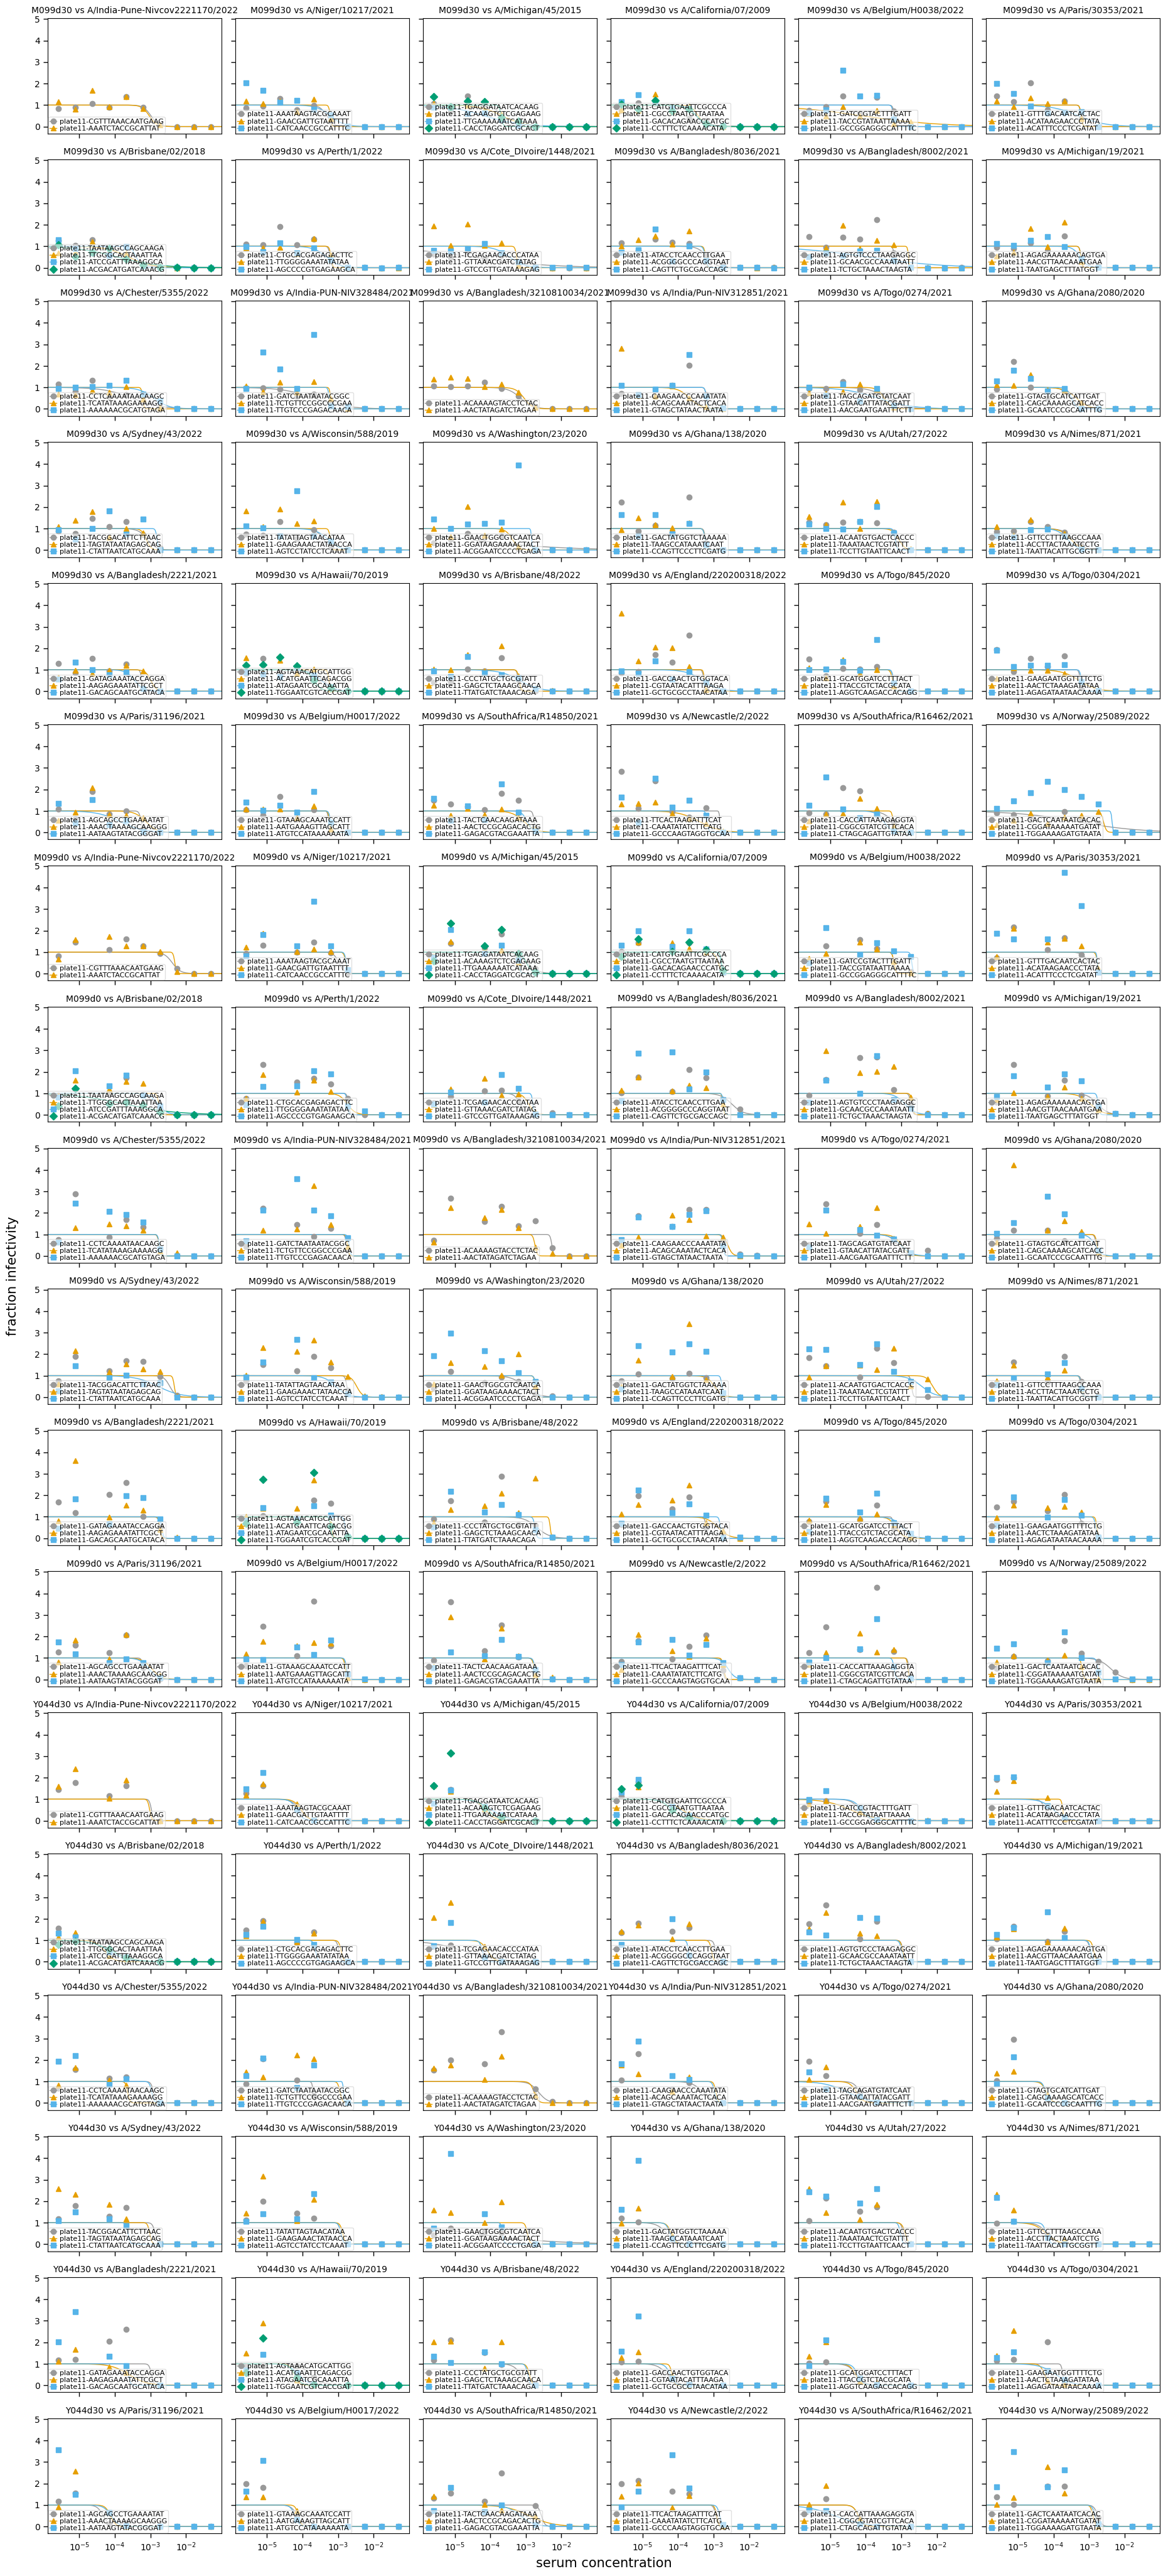

In [16]:
fits_nofilter = neutcurve.CurveFits(
    frac_infectivity.rename(
        columns={
            "frac_infectivity": "fraction infectivity",
            "concentration": "serum concentration",
        }
    ),
    conc_col="serum concentration",
    fracinf_col="fraction infectivity",
    virus_col="strain",
    serum_col="serum",
    replicate_col="plate_barcode",
)

_ = fits_nofilter.plotReplicates(
    attempt_shared_legend=False,
    legendfontsize=8,
    titlesize=10,
    ticksize=10,
    ncol=6,
)

In [17]:
for prop, col, agg in [
    ("number of dilutions", "dilution_factor", "nunique"),
    ("max frac infectivity", "frac_infectivity", "max"),
    ("min frac infectivity", "frac_infectivity", "min"),
]:
    prop_summary = (
        frac_infectivity
        .groupby(["serum_replicate", "strain", "barcode"], as_index=False)
        .aggregate(**{prop: pd.NamedAgg(col, agg)})
    )

    prop_summary_chart = (
        alt.Chart(prop_summary)
        .add_params(barcode_selection)
        .encode(
            alt.X(prop, scale=alt.Scale(nice=False, padding=4)),
            alt.Y("strain", title=None),
            alt.Column(
                "serum_replicate",
                title=None,
                header=alt.Header(labelFontSize=12, labelFontStyle="bold", labelPadding=0),
            ),
            strokeWidth=alt.condition(barcode_selection, alt.value(2), alt.value(0)),
            size=alt.condition(barcode_selection, alt.value(55), alt.value(35)),
            tooltip=[
                alt.Tooltip(c, format=".3g") if prop_summary[c].dtype == float else c
                for c in prop_summary.columns
            ],
        )
        .mark_circle(stroke="black", strokeOpacity=1, fillOpacity=0.45)
        .properties(
            height=alt.Step(10),
            width=120,
            title=alt.TitleParams(f"{prop} for each serum-replicate", dy=-2),
        )
    )

    display(prop_summary_chart)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

## Save results

Write fraction infectivities to file:

In [18]:
print(f"\nWriting fraction infectivities to {frac_infectivity_csv}")
(
    frac_infectivity[
        ["serum", "strain", "plate_barcode", "dilution_factor", "frac_infectivity"]
    ]
    .sort_values(["serum", "plate_barcode", "dilution_factor"])
    .to_csv(frac_infectivity_csv, index=False, float_format="%.5g")
)


Writing fraction infectivities to results/plates/plate11/frac_infectivity.csv
